In [1]:
from vae import VAE, VAE_Loss
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm


mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_dataset = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [2]:
#28x28 = 784
vae_model = VAE(latent_dim=64)

res = vae_model(mnist_dataset[0][0].unsqueeze(0))
res[0].shape

torch.Size([1, 1, 28, 28])

Training: 100%|██████████| 100/100 [06:00<00:00,  3.60s/it, train_loss=0.3750, test_loss=0.2921]


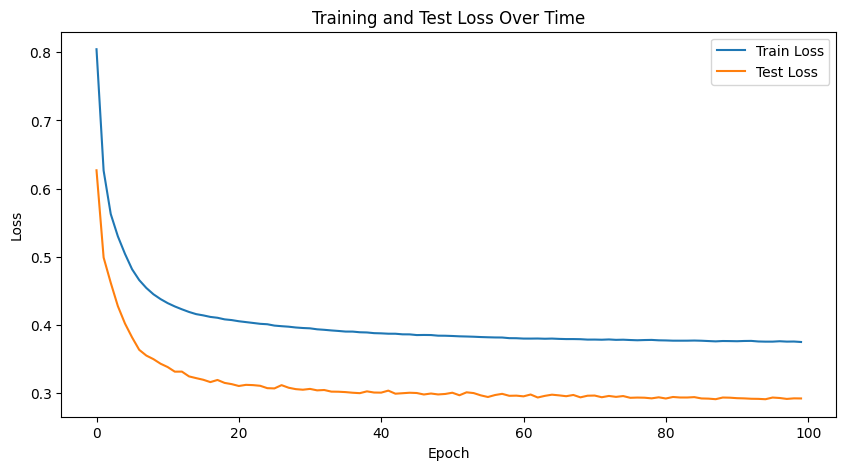

In [217]:
loss = VAE_Loss()#beta=1e-5
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

def train_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_fn((recon_batch, mu, logvar), data)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_fn((recon_batch, mu, logvar), data)
            total_loss += loss.item()
            
    return total_loss / len(test_loader)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model = vae_model.to(device)

# Create data loaders
bs = 512
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Training loop
n_epochs = 100
train_losses = []
test_losses = []

progress_bar = tqdm(range(n_epochs), desc='Training')
for epoch in progress_bar:
    train_loss = train_epoch(vae_model, train_loader, optimizer, loss, device)
    test_loss = evaluate(vae_model, test_loader, loss, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    progress_bar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'test_loss': f'{test_loss:.4f}'
    })

# Plot training and test losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
vae_model.load_state_dict(torch.load('vae_model.pth'))

/tmp/ipykernel_11200/1004363676.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model.pth'))


<All keys matched successfully>

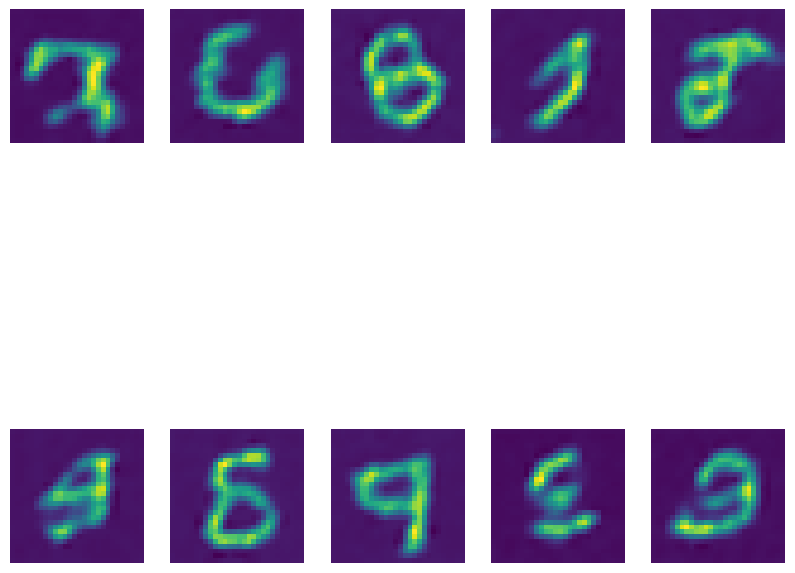

In [7]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(vae_model.generate(1)[0].cpu().detach().numpy().reshape(28,28))
    plt.axis('off')
plt.show()


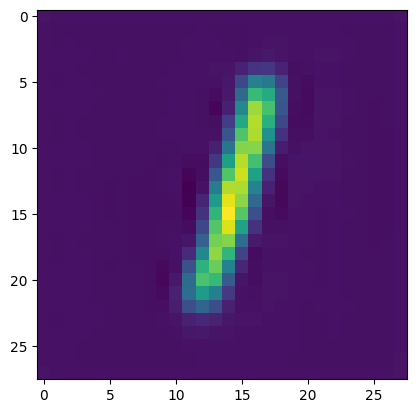

In [305]:
with torch.inference_mode():
    res = vae_model(test_dataset[2][0].unsqueeze(0).to(device))

plt.imshow(res[0].cpu().detach().numpy().reshape(28,28))
plt.show()


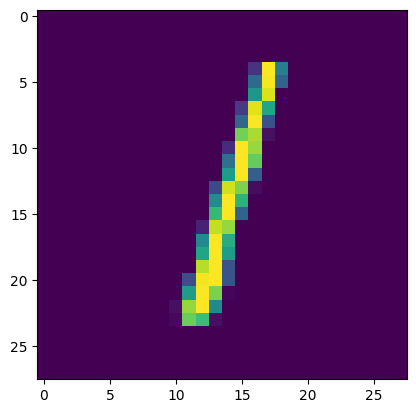

In [273]:
plt.imshow(test_dataset[2][0].numpy().reshape(28,28))
plt.show()


In [309]:
torch.save(vae_model.state_dict(), 'vae_model.pth')

In [314]:
torch.load('vae_model.pth')['encoder.0.weight']

/tmp/ipykernel_76511/2095461423.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('vae_model.pth')['encoder.0.weight']


tensor([[[[ 0.0023,  0.0274,  0.0190,  0.0135],
          [ 0.0095,  0.0076,  0.0041,  0.0229],
          [-0.0018, -0.0359, -0.0095,  0.0159],
          [-0.0349, -0.0311, -0.0357,  0.0022]]],


        [[[ 0.0181,  0.0723,  0.0544,  0.0115],
          [ 0.0189,  0.0280,  0.0336,  0.0146],
          [ 0.0131,  0.0401, -0.0337,  0.0151],
          [ 0.0214,  0.0055, -0.0016, -0.0033]]],


        [[[ 0.0110,  0.0183, -0.0174, -0.0476],
          [ 0.0048,  0.0163, -0.0466, -0.0219],
          [ 0.0187,  0.0118, -0.0027,  0.0060],
          [ 0.0017,  0.0123,  0.0114,  0.0236]]],


        [[[ 0.0067, -0.0048,  0.0338,  0.0084],
          [-0.0126,  0.0638,  0.0172,  0.0699],
          [ 0.0125,  0.0043,  0.0659,  0.0017],
          [-0.0034,  0.0212,  0.0083, -0.0012]]],


        [[[-0.0004, -0.0353, -0.0295, -0.0215],
          [ 0.0159, -0.0203, -0.0215,  0.0035],
          [ 0.0124, -0.0002,  0.0102,  0.0266],
          [ 0.0159,  0.0091,  0.0196,  0.0119]]],


        [[[-0.0568, 